In [1]:
%matplotlib inline

import torch.nn as nn

import torch.optim as optim


import torch
import torchvision
import math
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils import data
from torchvision import transforms
import seaborn as sns
sns.set()
import torch.nn.functional as F
from tqdm.notebook import tqdm


In [2]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=False)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=False)
len(mnist_train), len(mnist_test)

(60000, 10000)

In [3]:
train_set, val_set = torch.utils.data.random_split(mnist_train, [50000, 10000])
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(mnist_test, batch_size=1024, shuffle=False, drop_last=False)

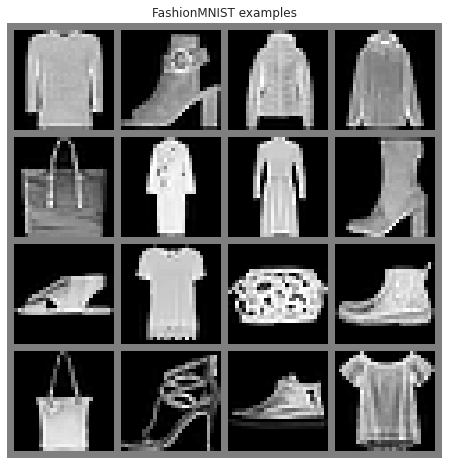

In [4]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [5]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
        # Defining optimizer, loss and data loader
    optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
    loss_module = nn.CrossEntropyLoss()
    train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
    device  = 'cuda:7'
    val_scores = []
    best_val_epoch = -1
    for epoch in range(max_epochs):
        ############
        # Training #
        ############
        net.train()
        true_preds, count = 0., 0
        for ind,(imgs, labels) in enumerate(train_loader_local):
            imgs, labels = imgs.to(device), labels.to(device) # To GPU
            optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
            preds = net(imgs)
            loss = loss_module(preds, labels)
            loss.backward()
            optimizer.step()
            # Record statistics during training
            true_preds += (preds.argmax(dim=-1) == labels).sum()
            count += labels.shape[0]
        train_acc = true_preds / count

        ##############
        # Validation #
        ##############
        val_acc = test_model(net, val_loader)
        val_scores.append(val_acc)
        if epoch%5==0:
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")


        # Plot a curve of the validation accuracy
        # plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        # plt.xlabel("Epochs")
        # plt.ylabel("Validation accuracy")
        # plt.title(f"Validation performance of {model_name}")
        # plt.show()
        # plt.close()

    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [6]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) # nn.Sequential summarizes a list of modules into a single module, applying them in sequence

        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector
        out = self.layers(x)
        return out

In [7]:
class ActivationFunction(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

class Sigmoid(ActivationFunction):

    def forward(self, x):
        return 1 / (1 + torch.exp(-x))


class Tanh(ActivationFunction):

    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)


class ReLU(ActivationFunction):

    def forward(self, x):
        return x * (x > 0).float()

 

class LeakyReLU(ActivationFunction):

    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

 

class ELU(ActivationFunction):

    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x)-1)

 

class Swish(ActivationFunction):

    def forward(self, x):
        return x * torch.sigmoid(x)


In [8]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

In [10]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor.
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"

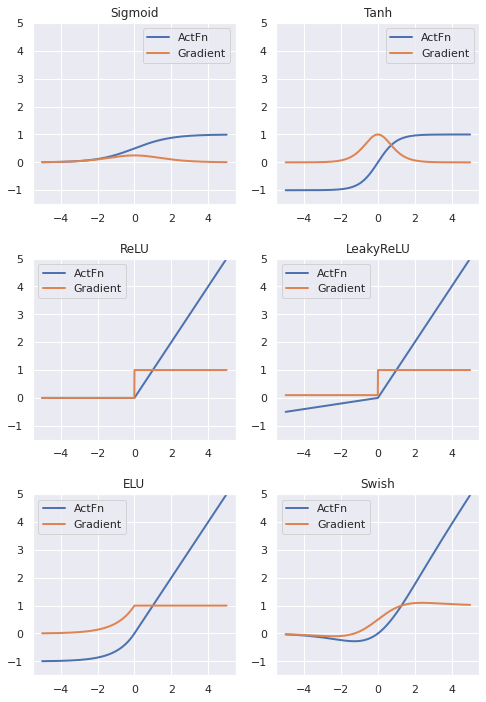

In [11]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

In [12]:
device = 'cuda:7'
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}",max_epochs=10, overwrite=False)

Training BaseNetwork with sigmoid activation...
[Epoch  1] Training accuracy: 09.96%, Validation accuracy: 09.76%
[Epoch  6] Training accuracy: 09.85%, Validation accuracy: 09.76%
============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...
[Epoch  1] Training accuracy: 56.39%, Validation accuracy: 74.42%
[Epoch  6] Training accuracy: 85.17%, Validation accuracy: 84.72%
============= Test accuracy: 85.04% ==============

Training BaseNetwork with relu activation...
[Epoch  1] Training accuracy: 29.94%, Validation accuracy: 61.32%
[Epoch  6] Training accuracy: 84.20%, Validation accuracy: 83.85%
============= Test accuracy: 85.46% ==============

Training BaseNetwork with leakyrelu activation...
[Epoch  1] Training accuracy: 34.44%, Validation accuracy: 61.32%
[Epoch  6] Training accuracy: 84.69%, Validation accuracy: 84.65%
============= Test accuracy: 85.88% ==============

Training BaseNetwork with elu activation...
[Epoch  1] Training accuracy: 53

In [16]:
class BaseNetwork_withDropout(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn,nn.Dropout(0.6)]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) # nn.Sequential summarizes a list of modules into a single module, applying them in sequence

        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector
        out = self.layers(x)
        return out

In [ ]:
device = 'cuda:7'
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork_withDropout(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}",max_epochs=10, overwrite=False)